<a href="https://colab.research.google.com/github/shadab4150/Eye-Disease-Detection/blob/master/SightNet_Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip '/content/drive/My Drive/Dataset/eye_both_small.zip' -d '/content/eye/'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from fastai.vision import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/eye_both_new.csv')

In [12]:
df.sample(n=6)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetic,Glaucoma,Cataract,AMD,Hypertension,Myopia,Other_abnormalities,file_name,fn_name
2043,2666,61,Male,2666_left.jpg,2666_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,2666.png,2666
663,665,54,Male,665_left.jpg,665_right.jpg,epiretinal membrane over the macula,macular epiretinal membrane,0,0,0,0,0,0,0,1,665.png,665
92,92,53,Male,92_left.jpg,92_right.jpg,normal fundus,retinitis pigmentosa,0,0,0,0,0,0,0,1,92.png,92
816,818,52,Male,818_left.jpg,818_right.jpg,hypertensive retinopathy，moderate non prolifer...,hypertensive retinopathy,0,1,0,0,0,1,0,0,818.png,818
985,990,41,Female,990_left.jpg,990_right.jpg,normal fundus,macular epiretinal membrane,0,0,0,0,0,0,0,1,990.png,990
2415,3038,66,Male,3038_left.jpg,3038_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,3038.png,3038


In [38]:
df.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'Normal',
       'Diabetic', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia',
       'Other_abnormalities', 'file_name', 'fn_name'],
      dtype='object')

In [0]:
df1 = df[['Normal',
       'Diabetic', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia',
       'Other_abnormalities']].copy()

In [0]:
arr = []
for i in range(df.shape[0]):
  val = df1.iloc[i].values
  arr.append(val)

In [73]:
clas = data.classes;clas

['Normal',
 'Diabetic',
 'Glaucoma',
 'Cataract',
 'AMD',
 'Hypertension',
 'Myopia',
 'Other_abnormalities']

In [0]:
from tqdm import tqdm,tnrange

In [75]:
arr1 = []
for i in tqdm(range(3500)):
  val1 = []
  for j in range(8):
    s = arr[i][j]
    if s==1:
      val1.append(clas[j])
  if len(val1)==0:
    arr1.append(['Normal'])
  else:
    arr1.append(val1)


100%|██████████| 3500/3500 [00:00<00:00, 130916.54it/s]


In [76]:
disease = []
for i in tqdm(range(3500)):
  sh = arr1[i]
  sh = "/".join(str(x) for x in sh)
  disease.append(sh)

100%|██████████| 3500/3500 [00:00<00:00, 435972.44it/s]


In [0]:
df['diagnosis'] = disease

In [0]:
df.to_csv('eye_multilabel.csv',index=False)

In [81]:
df.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetic,Glaucoma,Cataract,AMD,Hypertension,Myopia,Other_abnormalities,file_name,fn_name,diagnosis
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,0.png,0,Cataract
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,1.png,1,Normal


In [5]:
data=None
learn=None
gc.collect()

24

In [0]:
path = Path('/content/')

In [0]:
label = ['Normal','Diabetic', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia','Other_abnormalities']
data = (ImageList.from_df(df,path,folder='eye',suffix='.png',cols='file_name')
                .split_by_rand_pct(0.12,seed=364)
                .label_from_df(cols='diagnosis',label_delim='/')  #label_cls=MultiCategoryList,one_hot=True)
                .transform(get_transforms(do_flip=True,max_warp=None,max_rotate=None))
                .databunch(bs=32)).normalize(imagenet_stats)

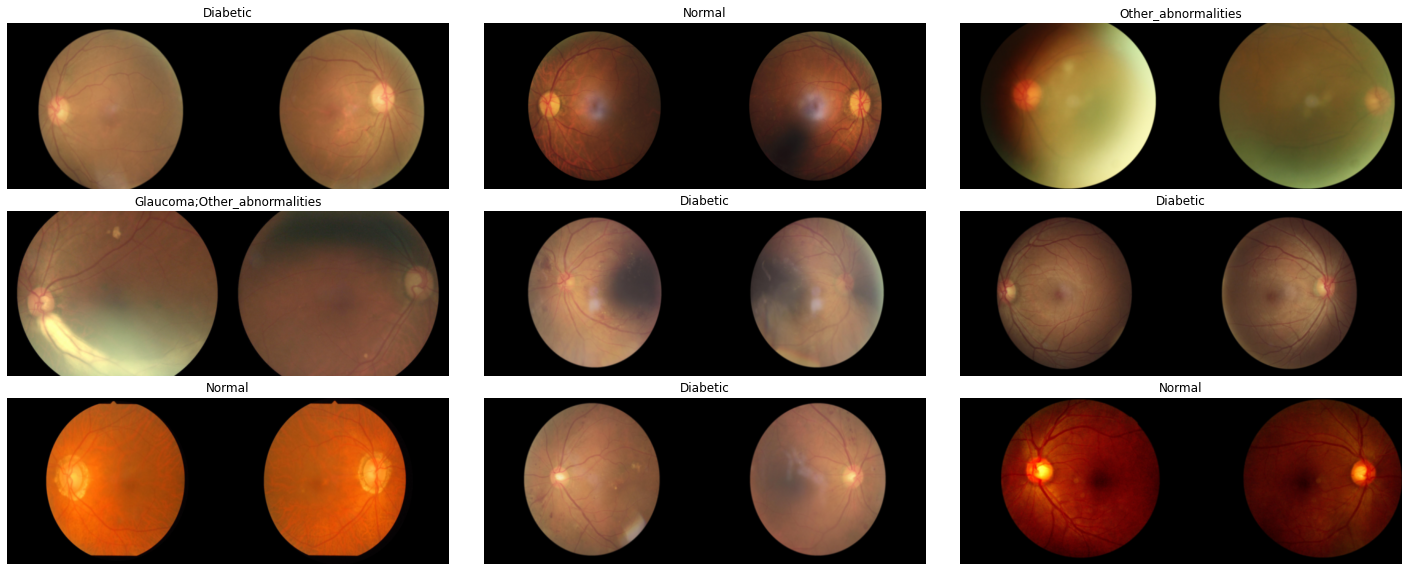

In [85]:
data.show_batch(rows=3,figsize=(20,8))

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): 
		return x + self.conv2D(self.conv1(x))


def conv2D(ni,nf):
  return nn.Conv2d(ni,nf,kernel_size=3,stride=2,padding=1)



def conv2res(ni,nf): 
    # ni = number of channels in 
    # nf = number of channels out
	return nn.Sequential(conv2D(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(

    conv2D(3, 8), nn.BatchNorm2d(8),nn.ReLU(),nn.Dropout(0.5),
    conv2D(8, 64), nn.BatchNorm2d(64),nn.ReLU(),nn.Dropout(0.6),
    conv2D(64, 256), nn.BatchNorm2d(256),nn.ReLU(),nn.Dropout(0.6),
    conv2D(256, 512), nn.BatchNorm2d(512),nn.ReLU(),nn.Dropout(0.65),
    conv2D(512, 256), nn.BatchNorm2d(256),nn.ReLU(),nn.Dropout(0.5),
    conv2D(256, 128), nn.BatchNorm2d(128),nn.ReLU(),nn.Dropout(0.5),
    conv2D(128,64),nn.BatchNorm2d(64),nn.ReLU(),
    Flatten(),nn.BatchNorm1d(256),
    nn.Linear(256,128),nn.ReLU(),nn.BatchNorm1d(128),nn.Dropout(0.5),
    nn.Linear(128,64),nn.ReLU(),nn.BatchNorm1d(64),nn.Dropout(0.5),
    nn.Linear(64,8)
	
)

In [86]:
data.classes

['AMD',
 'Cataract',
 'Diabetic',
 'Glaucoma',
 'Hypertension',
 'Myopia',
 'Normal',
 'Other_abnormalities']

In [87]:
acc_02 = partial(accuracy_thresh, thresh=0.4)
f_score = partial(fbeta, thresh=0.4)
learn = cnn_learner(data, models.resnet34, metrics = [acc_02,f_score])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [88]:
gc.collect()

39783

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


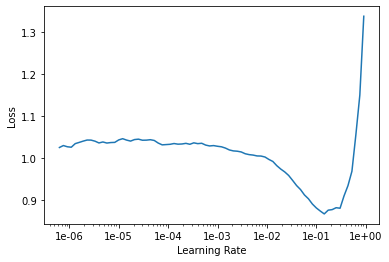

In [89]:
learn.lr_find()
learn.recorder.plot()

In [15]:
gc.collect()

13

In [10]:
np.linspace(1e-2,1e-1,5)

array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])

In [12]:
learn.fit_one_cycle(5, slice(0.0325))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.498137,0.386289,0.786012,0.493116,01:37
1,0.376735,0.289319,0.782738,0.672230,01:35
2,0.312379,0.275768,0.793750,0.677131,01:35
3,0.280471,0.274660,0.814286,0.675085,01:35
4,0.261330,0.265027,0.816667,0.685401,01:36


In [0]:
learn.fit_one_cycle(5, slice(0.0325),moms=0.9)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.511803,0.393035,0.831548,0.354724,01:12


In [0]:
learn.save('eye_model1')

In [0]:
learn.export('/content/drive/My Drive/Dataset/eye_first.pkl')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


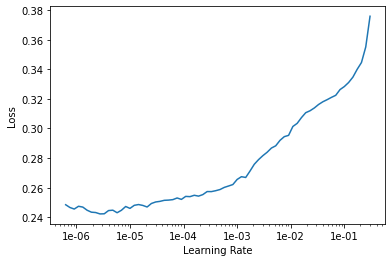

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [25]:
gc.collect()

28

In [18]:
np.linspace(1e-6,1e-5,5)

array([1.00e-06, 3.25e-06, 5.50e-06, 7.75e-06, 1.00e-05])

In [20]:
learn.fit_one_cycle( 3 , max_lr =slice(1e-6,5.50e-06))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.250759,0.263687,0.816369,0.693302,02:04
1,0.251659,0.263274,0.818452,0.692735,02:03
2,0.247365,0.262732,0.816667,0.688801,02:03


In [0]:
learn.save('eye_model1')

In [0]:
#learn.export('/content/drive/My Drive/Dataset/eye_first_7.pkl')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


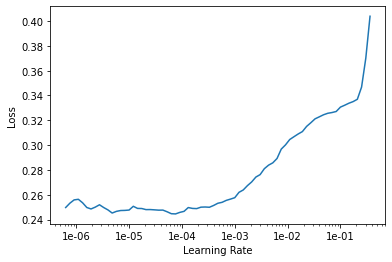

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr = slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.248581,0.261412,0.813393,0.699438,02:03
1,0.242914,0.258134,0.811310,0.703298,02:04
2,0.228252,0.254226,0.821726,0.711603,02:03
3,0.216895,0.256090,0.819048,0.714003,02:03


In [0]:
learn.save('eye_model2')

In [0]:
learn.export('/content/drive/My Drive/Dataset/eye_first_714.pkl')

In [69]:
interp = ClassificationInterpretation.from_learner(learn)

173 misclassified samples over 420 samples in the validation set.


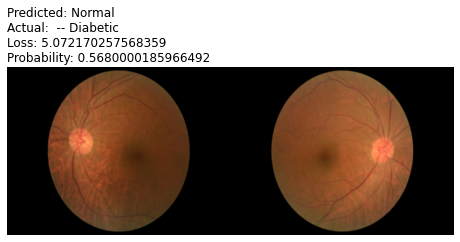

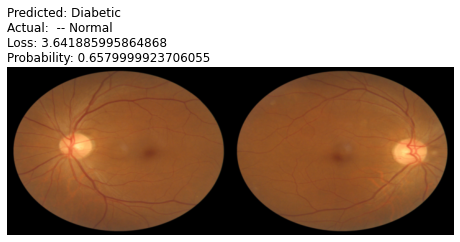

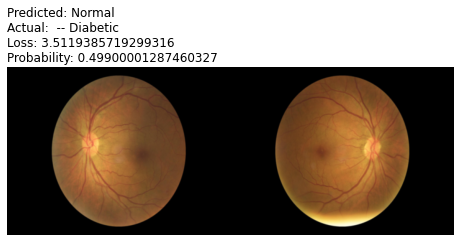

In [76]:
interp.plot_multi_top_losses()

In [25]:
df.sample(n=15)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,Normal,Diabetic,Glaucoma,Cataract,AMD,Hypertension,Myopia,Other_abnormalities,file_name,fn_name
2321,2944,64,Female,2944_left.jpg,2944_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,2944.png,2944
2397,3020,45,Female,3020_left.jpg,3020_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,3020.png,3020
1896,2519,61,Female,2519_left.jpg,2519_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,2519.png,2519
1406,1590,1,Female,1590_left.jpg,1590_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,1590.png,1590
290,291,67,Male,291_left.jpg,291_right.jpg,normal fundus,moderate non proliferative retinopathy，myelina...,0,1,0,0,0,0,0,1,291.png,291
787,789,65,Female,789_left.jpg,789_right.jpg,normal fundus,branch retinal vein occlusion,0,0,0,0,0,0,0,1,789.png,789
802,804,62,Female,804_left.jpg,804_right.jpg,normal fundus,spotted membranous change,0,0,0,0,0,0,0,1,804.png,804
2284,2907,58,Male,2907_left.jpg,2907_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,2907.png,2907
1138,1207,61,Female,1207_left.jpg,1207_right.jpg,macular epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,1207.png,1207
766,768,65,Female,768_left.jpg,768_right.jpg,spotted membranous change,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,768.png,768


In [0]:
model = load_learner('/content/drive/My Drive/Dataset/','eye_first_714.pkl')

In [27]:
img = open_image('/content/eye/1830.png.png')
model.predict(img)

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([3.3266e-02, 3.9443e-01, 4.9260e-03, 3.8178e-04, 2.6107e-01, 2.8409e-02,
         8.8817e-04, 3.8956e-01]))

In [28]:
a = model.predict(img)[2].numpy(); a

array([3.326647e-02, 3.944267e-01, 4.926044e-03, 3.817797e-04, 2.610725e-01, 2.840941e-02, 8.881683e-04, 3.895619e-01],
      dtype=float32)

In [35]:
a[a.argmax()],data.classes[a.argmax()]

(0.39442667, 1, 'Diabetic')

In [31]:
data.classes

['Normal',
 'Diabetic',
 'Glaucoma',
 'Cataract',
 'AMD',
 'Hypertension',
 'Myopia',
 'Other_abnormalities']